In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = torch.device("cpu")

cpu


In [2]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# %cd /content/drive/My Drive/Colab Notebooks/zDeep/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/zDeep


In [2]:
start_epoch = 0

In [3]:
from workspace import *

import data

import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt ###

start = time.time()
train = data.SDFDataset(data_dir, "train", order=order, load_ram=True)
train_loader = DataLoader(train, shuffle=True, batch_size=batch_size)
end = time.time()
print("Data loaded in ", end-start, " seconds")

Data loaded in  3.7437198162078857  seconds


In [4]:
from decoder import Decoder
from utils import *
import data

import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import time

def save_model(epoch, decoder, lat_vecs, optimizer, name):
    path = os.path.join(model_dir, model_params_subdir)
    if not os.path.isdir(path):
        os.makedirs(path)

    torch.save({
        'epoch': epoch,
        'model_state_dict': decoder.state_dict(),
        'lat_vecs': lat_vecs.state_dict(),
        'optimizer': optimizer.state_dict()
    }, os.path.join(path, name))

def save_logs(loss, lat_mag, moment, time, name):
    path = os.path.join(model_dir, model_logs_subdir)
    if not os.path.isdir(path):
        os.makedirs(path)

    torch.save({
        'loss': loss,
        'lat_mag': lat_mag,
        'moment': moment,
        'time': time
    }, os.path.join(path, name))

def get_mean_latent_vector_magnitude(latent_vectors):
    return torch.mean(torch.norm(latent_vectors.weight.data.detach(), dim=1)).item()

decoder = Decoder().to(device)
num_shapes = len(train)

lat_vecs = torch.nn.Embedding(num_shapes, latent_size, max_norm=1)
torch.nn.init.normal_(lat_vecs.weight.data, 0.0, sigma / np.sqrt(latent_size))

loss_l1 = torch.nn.L1Loss(reduction="sum")
optimizer_all = torch.optim.Adam(
    [
        {
            "params": decoder.parameters(),
            "lr": lr,
        },
        {
            "params": lat_vecs.parameters(),
            "lr": lr,
        },
    ]
)
optimizer_angle = torch.optim.Adam(decoder.parameters(), lr=lra)


loss_log = []
lat_mag_log = []
mom_log = []
time_log = []

if start_epoch > 0:
    cp = torch.load(os.path.join(model_dir, model_params_subdir, f"cp_{start_epoch}.pth"), map_location=device)
    logs_cp = torch.load(os.path.join(model_dir, model_logs_subdir, f"log_{start_epoch}.pth"), map_location=device)

    decoder.load_state_dict(cp["model_state_dict"])
    lat_vecs.load_state_dict(cp["lat_vecs"])

    loss_log = logs_cp["loss"]
    lat_mag_log = logs_cp["lat_mag"]
    mom_log = logs_cp["moment"]
    time_log = logs_cp["time"]

    mms = []
    for m in mom_log:
      mms.append(m.cpu())
    mom_log = mms

for epoch in tqdm(range(start_epoch + 1, num_epochs + 1)):
    if epoch > start_epoch + 1 and epoch % int(num_epochs/10) == 0:
        fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(14, 4))
        ax2.plot(loss_log)
        ax2.set_title("loss")
        ax3.plot(lat_mag_log)
        ax3.set_title("mag")
        ax4.plot(mom_log)
        ax4.set_title("moments")
        plt.show()

    decoder.train()

    start = time.time()
    loss_total = 0

    for sdf_data, moments, indices in train_loader:
        optimizer_all.zero_grad()

        sdf_data.requires_grad = False
        moments.requires_grad = False

        sdf_data = sdf_data.to(device)

        sdf_data = sdf_data.reshape(-1, 3)
        num_sdf_samples = sdf_data.shape[0]

        x = sdf_data[:, 0:2]
        sdf_gt = sdf_data[:, 2].unsqueeze(1)

        if order == 2:
            l2, l3 = moments[:, 0], moments[:, 1]
            g = (torch.atan2(l3, l2)/2).unsqueeze(1).repeat(1, num_samp_per_scene).view(-1)
        else:
            l3, l4 = moments[:, 0], moments[:, 1]
            g = (torch.atan2(l4, l3)).unsqueeze(1).repeat(1, num_samp_per_scene).view(-1)
        indices = indices.unsqueeze(-1).repeat(1, num_samp_per_scene).view(-1)
        batch_vecs = lat_vecs(indices)

        g = g.to(device)
        x = x.to(device)
        batch_vecs = batch_vecs.to(device)

        pred_sdf = decoder(g, x, batch_vecs)

        sdf_loss = loss_l1(pred_sdf, sdf_gt) / num_sdf_samples
        reg_loss = code_reg_lambda * torch.sum(torch.norm(batch_vecs, dim=1)) / num_sdf_samples

        loss = sdf_loss + reg_loss
        loss.backward()
        loss_total += loss.item()
        optimizer_all.step()


    end = time.time()
    seconds_elapsed = end - start

    loss_log.append(loss_total)
    lat_mag_log.append(get_mean_latent_vector_magnitude(lat_vecs))
    time_log.append(seconds_elapsed)

#################################################################################################

    norm = lat_mag_log[-1]
    bound = np.sqrt(3*norm**2 / latent_size)
    rand_vecs = torch.nn.Embedding(num_shapes, latent_size, max_norm=1)
    torch.nn.init.uniform_(rand_vecs.weight.data, -bound, bound)

    moment_loss = 0
    all_indices = range(num_shapes)
    batches = [all_indices[i:i + batch_size] for i in range(0, num_shapes, batch_size)]
    for batch in (batches):
        batch_loss = 0
        y_coords, x_coords = torch.meshgrid(torch.arange(sidelen, dtype=torch.float32), torch.arange(sidelen, dtype=torch.float32), indexing="xy")
        pixel_coords = torch.stack([x_coords, y_coords], dim=-1)[None, ...]
        pixel_coords /= sidelen
        pixel_coords -= 0.5
        pixel_coords = pixel_coords.view(-1, 2)
        x = pixel_coords

        indices = torch.tensor(batch).unsqueeze(-1).repeat(1, x.shape[0]).view(-1)
        x = x.repeat(len(batch), 1).to(device)

        z = rand_vecs(indices).to(device)
        g = torch.tensor([0]).to(device)

        x.requires_grad = False
        g.requires_grad = False
        z.detach()

        pred = decoder(g, x, z)

        i = 0
        for _ in batch:
            pred_sdf = pred.cpu()
            pred_sdf = pred[i * sidelen**2:(i+1)*sidelen**2]
            pred_sdf = pred_sdf.reshape((sidelen, sidelen))
            pred_sdf[pred_sdf <= 0] = 0
            pred_sdf[pred_sdf > 0] = 1
            pred_sdf = 1 - pred_sdf
            img = pred_sdf.cpu()
            i += 1

            def raw_moment(img, i_order, j_order):
                nrows, ncols = img.shape
                y_indices, x_indices = torch.meshgrid(torch.arange(nrows), torch.arange(ncols), indexing='ij')
                return (img * (x_indices**i_order) * (y_indices**j_order)).sum()

            m00 = img.sum()
            if m00 == 0:
                continue

            m10 = raw_moment(img, 1, 0)
            m01 = raw_moment(img, 0, 1)
            m20 = raw_moment(img, 2, 0)
            m11 = raw_moment(img, 1, 1)
            m02 = raw_moment(img, 0, 2)
            m30 = raw_moment(img, 3, 0)
            m21 = raw_moment(img, 2, 1)
            m12 = raw_moment(img, 1, 2)
            m03 = raw_moment(img, 0, 3)

            x_centroid = m10 / m00
            y_centroid = m01 / m00

            if order == 2:
                mu20 = (m20 - x_centroid * m10) / m00
                mu11 = (m11 - x_centroid * m01) / m00
                mu02 = (m02 - y_centroid * m01) / m00

                lnd2 = (mu20 - mu02)/2
                lnd3 = mu11

                angle_loss = torch.rad2deg(torch.atan2(lnd3, lnd2)/2)
            else:
                mu30 = (m30 - 3 * x_centroid * m20 + 2 * x_centroid**2 * m10) / m00
                mu21 = (m21 - 2 * x_centroid * m11 - y_centroid * m20 + 2 * x_centroid**2 * m01) / m00
                mu12 = (m12 - 2 * y_centroid * m11 - x_centroid * m02 + 2 * y_centroid**2 * m10) / m00
                mu03 = (m03 - 3 * y_centroid * m02 + 2 * y_centroid**2 * m01) / m00

                lrd3 = mu30 + mu12
                lrd4 = mu21 + mu03

                angle_loss = torch.rad2deg(torch.atan2(lrd4, lrd3))

            batch_loss += torch.abs(angle_loss)

        if batch_loss != 0:
            optimizer_angle.zero_grad()
            batch_loss.backward()
            optimizer_angle.step()
        moment_loss += batch_loss.detach()

    mom_log.append(moment_loss / num_shapes)
    if epoch > 1 and epoch % 50 == 0:
        save_model(epoch, decoder, lat_vecs, optimizer_all, f"cp_{epoch}.pth")
        save_logs(loss_log, lat_mag_log, mom_log, time_log, f"log_{epoch}.pth")

save_model(epoch, decoder, lat_vecs, optimizer_all, "latest.pth")
save_logs(loss_log, lat_mag_log, mom_log, time_log, "latest.pth")

  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

[tensor(4.7550), tensor(14.9389), tensor(6.9198), tensor(4.8083), tensor(17.8118), tensor(15.7492), tensor(9.7058), tensor(9.4402), tensor(13.1669), tensor(12.4588), tensor(15.8604), tensor(16.5047), tensor(19.0026), tensor(20.6181), tensor(20.5107), tensor(23.8989), tensor(25.7378), tensor(21.8550), tensor(23.9577), tensor(27.2872), tensor(27.0392), tensor(26.6505), tensor(23.3128), tensor(26.6536), tensor(24.5937), tensor(24.4426), tensor(29.4467), tensor(25.6923), tensor(23.9865), tensor(22.9330), tensor(26.0325), tensor(23.8920), tensor(21.5537), tensor(25.4113), tensor(20.3455), tensor(24.5465), tensor(20.6741), tensor(22.9359), tensor(25.2164), tensor(24.2730), tensor(21.5805), tensor(22.2708), tensor(21.2516), tensor(21.9115), tensor(22.1399), tensor(21.8672), tensor(21.7825), tensor(22.3574), tensor(23.9701), tensor(23.8505), tensor(22.4853), tensor(25.3957), tensor(23.0637), tensor(22.5464), tensor(22.7703), tensor(23.4963), tensor(21.1701), tensor(22.8863), tensor(22.3224), t

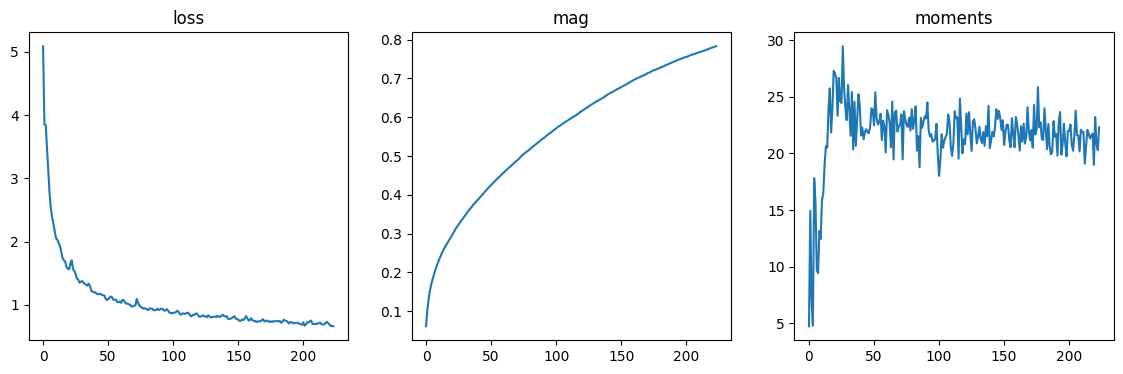

In [14]:
fig, (ax2, ax3, ax4) = plt.subplots(1, 3, figsize=(14, 4))
ax2.plot(loss_log)
ax2.set_title("loss")
ax3.plot(lat_mag_log)
ax3.set_title("mag")
ax4.plot(mom_log)
ax4.set_title("moments")
plt.show()

24.474542250754947


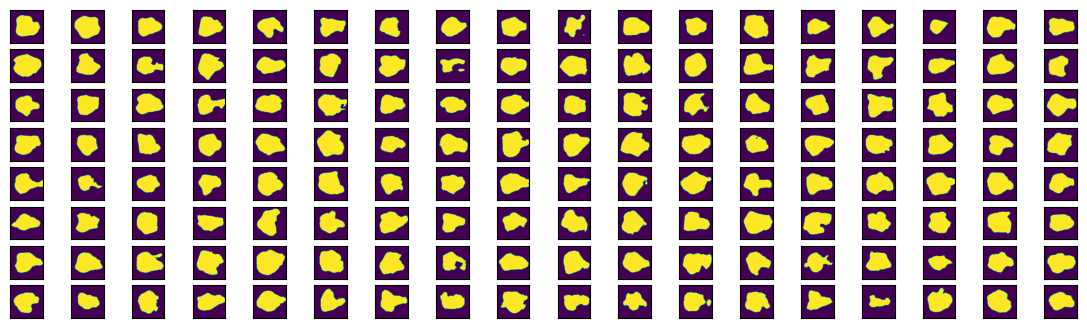

In [18]:
def get_mean_latent_vector_magnitude(latent_vectors):
    return torch.mean(torch.norm(latent_vectors.weight.data.detach(), dim=1)).item()

mag = (get_mean_latent_vector_magnitude(lat_vecs))
bound = np.sqrt(3*mag**2 / latent_size)
rand_vecs = torch.nn.Embedding(num_shapes, latent_size, max_norm=1)
torch.nn.init.uniform_(rand_vecs.weight.data, -bound, bound)

def eval():
    decoder.eval()
    decoder.cpu()
    fig, axs = plt.subplots(8, 18, figsize=(14, 4))
    x = torch.tensor(get_coordinate_grid(sidelen))
    g = torch.tensor([0])
    angle = 0
    for i, ax in enumerate(axs.ravel()):
    # if True:
    # for i in tqdm(range(num_shapes)):
        # z = rand_vecs(torch.randint(num_shapes, (1,))).detach()
        # z = lat_vecs(torch.tensor([torch.randint(num_shapes, (1,))])).detach()
        z = lat_vecs(torch.tensor([i]))
        z = rand_vecs(torch.tensor([i]))

        z = z.repeat(x.shape[0], 1)

        pred = decoder(g, x, z)

        # pred.cpu()
        sdf = np.append(x.numpy(), pred.detach().numpy(), axis=1)
        img = samples_to_img(sdf)

        # _, _, (l2, l3), _ = get_normalization_params(img)
        # angle += abs(np.degrees(np.arctan2(l3, l2) / 2))
        _, _, _, (l3, l4) = get_normalization_params(img)
        angle += abs(np.degrees(np.arctan2(l4, l3)))

        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])

    print(angle/i)
    plt.show()

eval()

# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14, 4))
# ax1.plot(time_log)
# ax1.set_title("time")
# ax2.plot(loss_log)
# ax2.set_title("loss")
# ax3.plot(lat_mag_log)
# ax3.set_title("mag")
# plt.show()